<a href="https://colab.research.google.com/github/Sahil2004/cs-practicals/blob/main/6th%20sem/%5B01%5D%20Data%20Mining%20and%20Analysis/%5B14%5D%20Practical%2010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            confusion_matrix, ConfusionMatrixDisplay,
                            precision_recall_curve, PrecisionRecallDisplay,
                            roc_auc_score, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, StackingClassifier,
                            GradientBoostingClassifier, ExtraTreesClassifier,
                            AdaBoostClassifier, HistGradientBoostingClassifier)
from xgboost import XGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting

In [19]:
file_name = "/content/CO22358_lung_cancer.csv"
dataset = pd.read_csv(file_name)

X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

In [20]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

# Convert all categorical columns except the last one using LabelEncoder
labelencoder_X = LabelEncoder()
for col in range(X.shape[1] - 1):  # All columns except the last
    X[:, col] = labelencoder_X.fit_transform(X[:, col])

# Convert the last column ('YES'/'NO') to 0/1
X[:, -1] = np.where(X[:, -1] == 'YES', 1, 0).astype(int)

# Optionally, apply OneHotEncoder to the first few columns if needed (skip the last one)
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), list(range(X.shape[1] - 1)))],
    remainder='passthrough'
)
X = ct.fit_transform(X)

# Encode target variable y
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

In [23]:
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, PrecisionRecallDisplay, precision_recall_curve
)

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    # ROC AUC Calculation (only if both classes exist in y_test)
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    if len(np.unique(y_test)) > 1:
        roc_auc = roc_auc_score(y_test, y_scores)
    else:
        roc_auc = None

    print(f"\n{'='*50}")
    print(f"Evaluation Metrics for {model_name}")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, pos_label=1):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, pos_label=1):.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}" if roc_auc is not None else "ROC AUC Score: Undefined (only one class present)")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Precision-Recall Curve (only if both classes exist)
    if len(np.unique(y_test)) > 1:
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_scores)
        disp = PrecisionRecallDisplay(precision=precision_curve, recall=recall_curve)
        disp.plot()
        plt.title(f'Precision-Recall Curve for {model_name}')
        plt.show()

In [26]:
# Building a stacking classifier similar to the reference regression approach
def build_stacking_classifier():
    # Base models
    base_models = [
        ('xgb', XGBClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss'
        )),
        ('rf', RandomForestClassifier(
            n_estimators=150,
            max_depth=12,
            min_samples_split=5,
            random_state=42
        )),
        ('et', ExtraTreesClassifier(
            n_estimators=150,
            max_depth=10,
            max_features=0.7,
            random_state=42
        )),
        ('gb', GradientBoostingClassifier(
            n_estimators=150,
            max_depth=5,
            learning_rate=0.05,
            random_state=42
        )),
        ('hgb', HistGradientBoostingClassifier(
            max_iter=200,
            learning_rate=0.05,
            max_depth=6,
            random_state=42
        ))
    ]

    # Final estimator
    final_estimator = LogisticRegression(
        C=0.1,
        penalty='l2',
        solver='liblinear',
        random_state=42
    )

    # Stacking classifier
    stacking_model = StackingClassifier(
        estimators=base_models,
        final_estimator=final_estimator,
        stack_method='predict_proba',
        n_jobs=-1
    )

    return stacking_model

In [27]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Linear SVM": SVC(kernel='linear', random_state=42, probability=True),
    "RBF SVM": SVC(kernel='rbf', random_state=42, probability=True),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Stacking Classifier": build_stacking_classifier()
}


Training Logistic Regression...

Evaluation Metrics for Logistic Regression
Accuracy: 0.9744
Precision: 0.9733
Recall: 1.0000
F1 Score: 0.9865
ROC AUC Score: 0.9534

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.97      1.00      0.99        73

    accuracy                           0.97        78
   macro avg       0.99      0.80      0.87        78
weighted avg       0.98      0.97      0.97        78



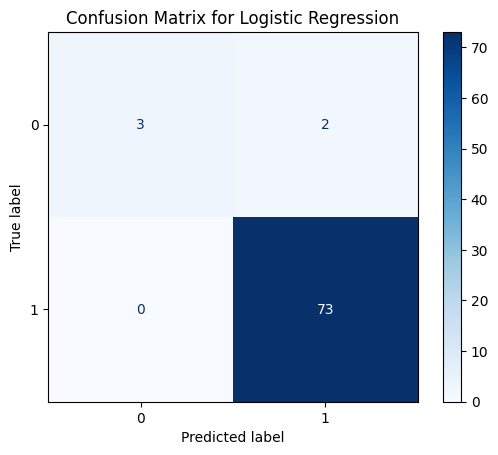

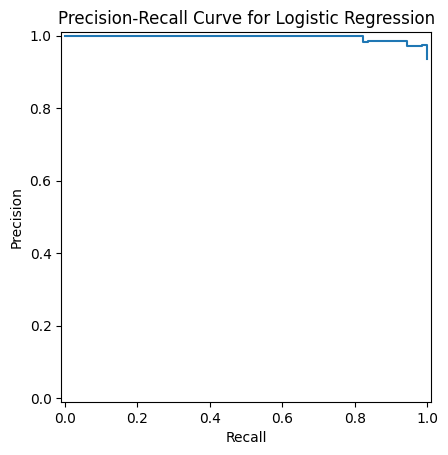


Training K-Nearest Neighbors...

Evaluation Metrics for K-Nearest Neighbors
Accuracy: 0.9359
Precision: 0.9595
Recall: 0.9726
F1 Score: 0.9660
ROC AUC Score: 0.8151

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.96      0.97      0.97        73

    accuracy                           0.94        78
   macro avg       0.73      0.69      0.71        78
weighted avg       0.93      0.94      0.93        78



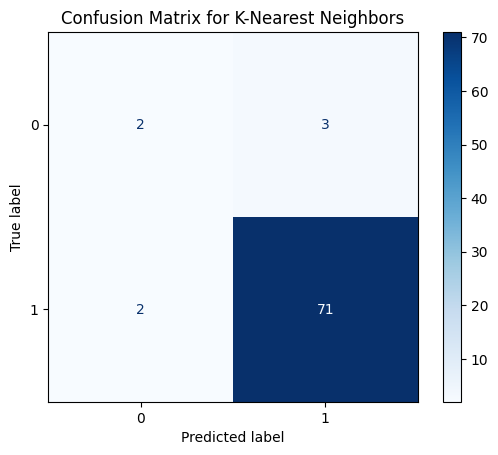

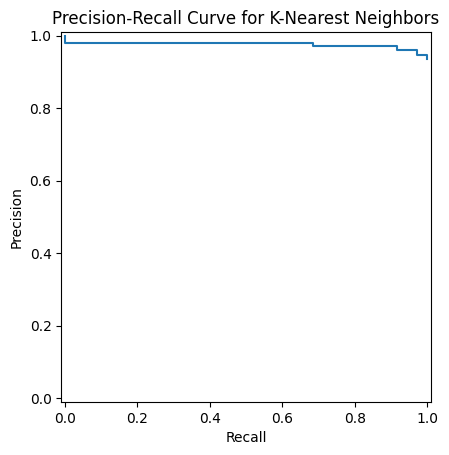


Training Linear SVM...

Evaluation Metrics for Linear SVM
Accuracy: 0.9615
Precision: 0.9730
Recall: 0.9863
F1 Score: 0.9796
ROC AUC Score: 0.9233

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.97      0.99      0.98        73

    accuracy                           0.96        78
   macro avg       0.86      0.79      0.82        78
weighted avg       0.96      0.96      0.96        78



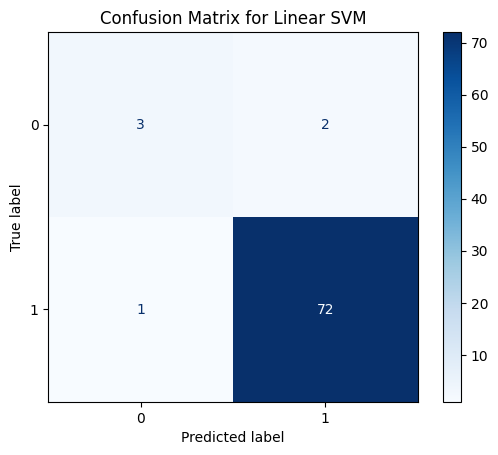

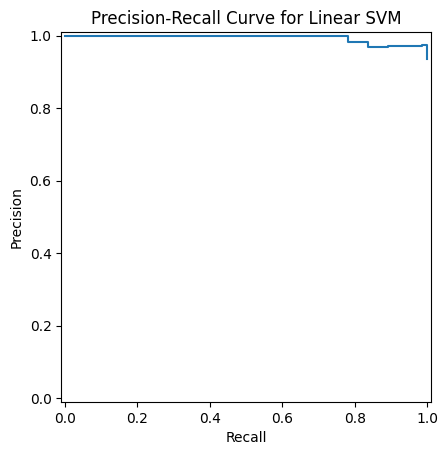


Training RBF SVM...

Evaluation Metrics for RBF SVM
Accuracy: 0.9615
Precision: 0.9605
Recall: 1.0000
F1 Score: 0.9799
ROC AUC Score: 0.9507

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.96      1.00      0.98        73

    accuracy                           0.96        78
   macro avg       0.98      0.70      0.78        78
weighted avg       0.96      0.96      0.95        78



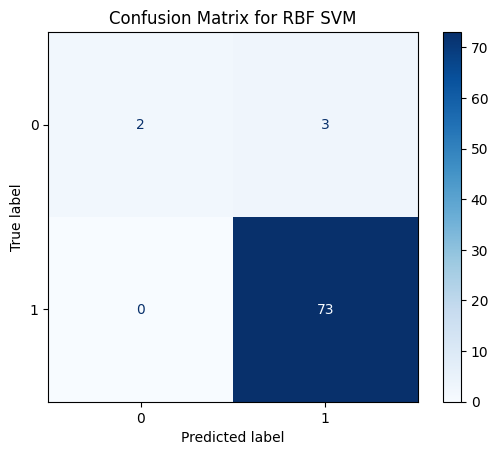

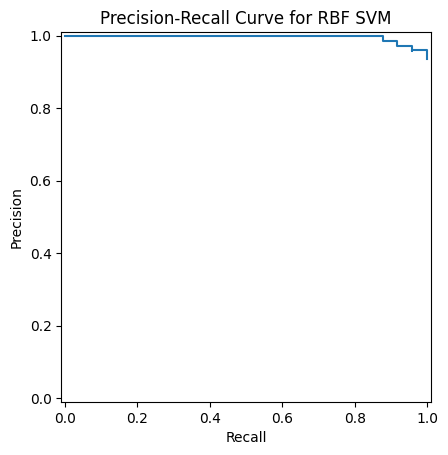


Training Naive Bayes...

Evaluation Metrics for Naive Bayes
Accuracy: 0.5256
Precision: 0.9737
Recall: 0.5068
F1 Score: 0.6667
ROC AUC Score: 0.7959

Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.80      0.18         5
           1       0.97      0.51      0.67        73

    accuracy                           0.53        78
   macro avg       0.54      0.65      0.42        78
weighted avg       0.92      0.53      0.64        78



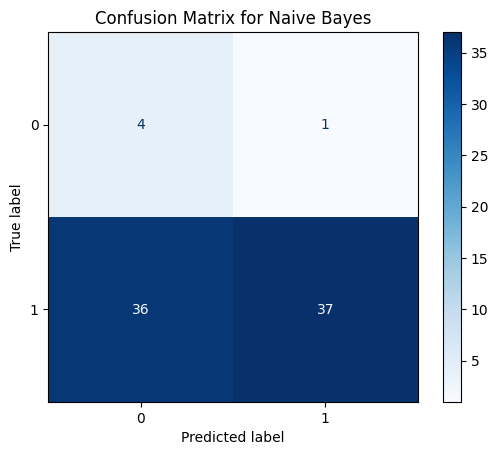

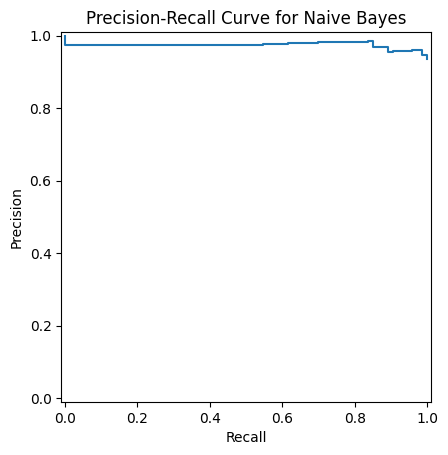


Training Decision Tree...

Evaluation Metrics for Decision Tree
Accuracy: 0.9231
Precision: 0.9589
Recall: 0.9589
F1 Score: 0.9589
ROC AUC Score: 0.6795

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.96      0.96      0.96        73

    accuracy                           0.92        78
   macro avg       0.68      0.68      0.68        78
weighted avg       0.92      0.92      0.92        78



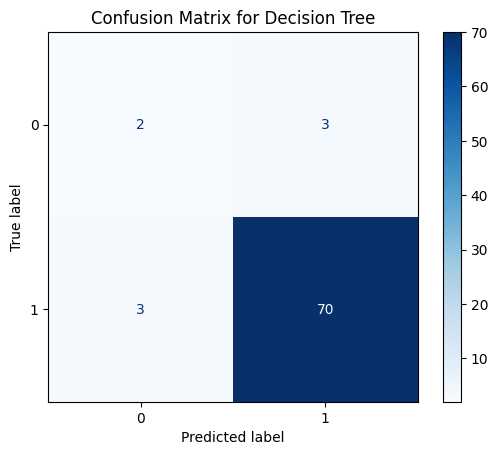

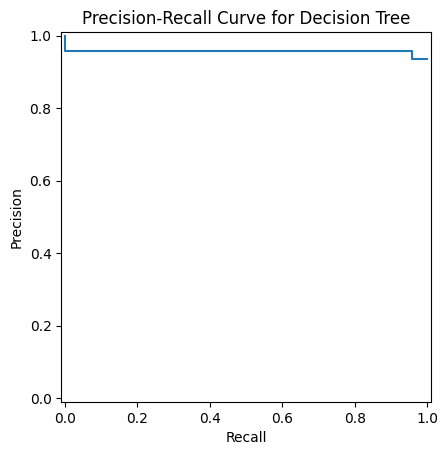


Training Random Forest...

Evaluation Metrics for Random Forest
Accuracy: 0.9615
Precision: 0.9730
Recall: 0.9863
F1 Score: 0.9796
ROC AUC Score: 0.9918

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.97      0.99      0.98        73

    accuracy                           0.96        78
   macro avg       0.86      0.79      0.82        78
weighted avg       0.96      0.96      0.96        78



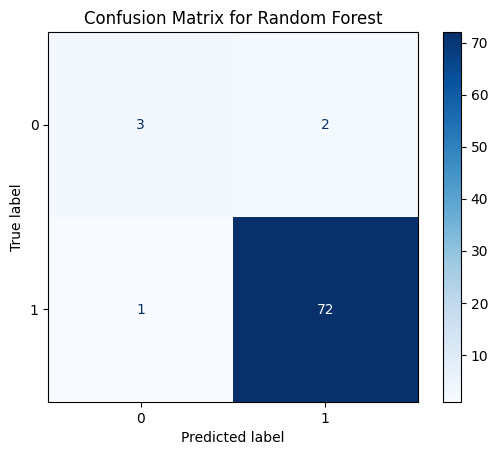

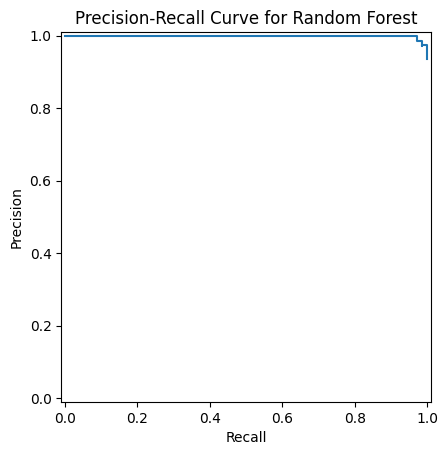


Training Stacking Classifier...

Evaluation Metrics for Stacking Classifier
Accuracy: 0.9359
Precision: 0.9359
Recall: 1.0000
F1 Score: 0.9669
ROC AUC Score: 0.9863

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.94      1.00      0.97        73

    accuracy                           0.94        78
   macro avg       0.47      0.50      0.48        78
weighted avg       0.88      0.94      0.90        78



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


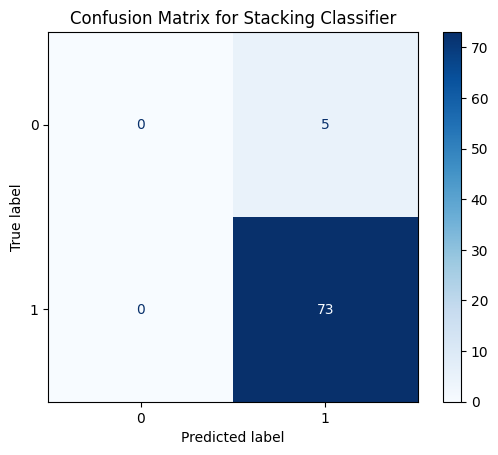

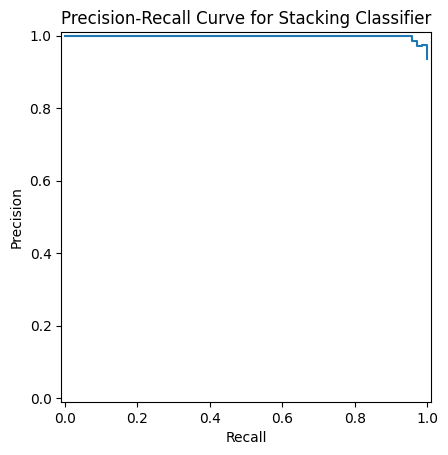

In [32]:
# Train and evaluate all models
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Convert to dense if the model is Naive Bayes and Stacking Classifier
    if name == "Naive Bayes" or name == "Stacking Classifier":
        model.fit(X_train.toarray(), y_train)
        evaluate_model(model, X_test.toarray(), y_test, name)
    else:
        model.fit(X_train, y_train)
        evaluate_model(model, X_test, y_test, name)

In [34]:
# Cross-validation for the stacking classifier
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
stacking_model = build_stacking_classifier()

# Convert sparse X_train to dense if necessary
X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train

cv_scores = cross_val_score(
    stacking_model,
    X_train_dense,
    y_train,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print("\nStacking Classifier Cross-Validation Results:")
print(f"Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")


Stacking Classifier Cross-Validation Results:
Accuracy Scores: [0.82758621 0.75862069 0.82758621 0.86206897 0.89655172]
Mean Accuracy: 0.8345
Standard Deviation: 0.0457
